## Shared Variance Component Analysis (SVCA): application to neural data

Apply SVCA to a neural dataset, see [this Neuromatch notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_stringer_spontaneous.ipynb). 

In [1]:
import numpy as np
from scipy.linalg import svd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from src import svca # SVCA and data split_data
from src.utils import fit_power_law

# Plotting
sns.set_context("poster")
sns.set_palette("colorblind")
GREEN = sns.color_palette()[2]
ORANGE = sns.color_palette()[3]
ALPHA = 0.7

In [2]:
# Constants
BIN_WIDTH = 60 # split neurons into x/y direction of BIN_WIDTH micrometer
N_DIMS = 1024 # Number of SVCs to compute


# Create results directories if necessary
FIGDIR = "../figures/"
DATADIR = "../data/"

if not os.path.exists(FIGDIR):
    os.mkdir(FIGDIR)
if not os.path.exists(DATADIR):
    os.mkdir(DATADIR)
    os.system("wget -O data/stringer_spontaneous.npy https://osf.io/dpqaj/download")

## Load the data

Previously preprocessed by Stringer et al.; we'll use the activity and position of the neurons, stored under keys `sresp` and `xzy`, respectively.

In [3]:
dat = np.load(DATADIR + 'stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())
neurons, bins = dat['sresp'].shape
print(f"Activity of {neurons} neurons in {bins} 1.2s time bins")

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])
Activity of 11983 neurons in 7018 1.2s time bins


## Split data

Key preprocessing step for SVCA: split data along time and neuron axes. Imaging data can be divided based on $x$ or $y$ coordinates (or both) 
to avoid overlap in the $z$ direction. Overlap in the $z$ direction could lead to spurious correlations between the neurons from fluoresence. 

In [4]:
Ftrain, Ftest, Gtrain, Gtest = svca.split_data(dat['sresp'].copy().T, dat['xyz'][0], bin_width=BIN_WIDTH)
print("Dimensions (time, neurons):")
print(f"Group 1 dimensions: {Ftrain.shape} (train) and {Ftest.shape} (test)")
print(f"Group 2 dimensions: {Gtrain.shape} (train) and {Gtest.shape} (test)")

/mnt/data/joram/SVCA/src/svca.py:92: UserWarning: Using bin_width variable to split neurons; ignoring neuron_bins
  warnings.warn(f"Using bin_width variable to split neurons; ignoring neuron_bins")


Dimensions (time, neurons):
Group 1 dimensions: (3538, 5765) (train) and (3480, 5765) (test)
Group 2 dimensions: (3538, 6218) (train) and (3480, 6218) (test)


# SVCA

Let's apply SVCA to the provided dataset and compare the results with those reported in the original paper, quoted here:

* The first 128 SVCs together accounted for 86 of the complete population’s reliable variance,
* 67 ± 3% SE of the total variance in these 128 dimensions was reliable. 
* The fraction of reliable variance in the first SVC was 97%, the 50th SVC at ~50% reliable variance and the 512th at ~9%.

These statics were computed across multiple datasets. Here we analyze only one dataset, but the results are qualitatively similar. 

In [5]:
# Covariance & SVD of large matrices - takes a few minutes depending on your machine
reliable_variance, all_variance, SVC1, SVC2 = svca.svca(Ftrain, Ftest, Gtrain, Gtest, n_dims=N_DIMS)

% of reliable variance in SVCs1-128: 86.85%
% of variance SVCs1-128 is reliable: 74.85%
Reliable var SVC1: 96.72%
Reliable var SVC1: 56.41%
Reliable var SVC512: 6.93%


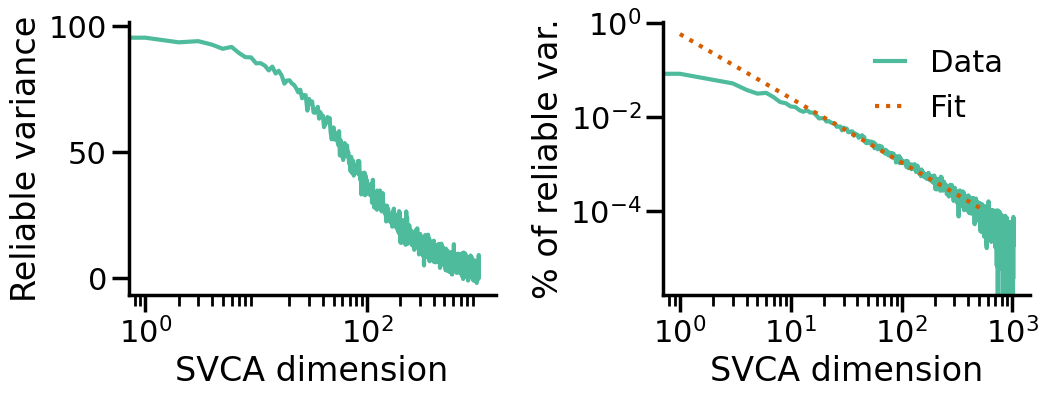

In [6]:
# Make scree plots
normalized_variance = reliable_variance / all_variance
fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

# % of variance that is reliable, i.e. shared between neuron groups
ax[0].semilogx(normalized_variance * 100,
               color=GREEN, alpha=ALPHA)
ax[0].set_ylabel("Reliable variance")
# Fraction of all reliable variance per dimension
ax[1].loglog(reliable_variance / np.sum(reliable_variance),
             color=GREEN, alpha=ALPHA, label = 'Data')
ax[1].set_ylabel("% of reliable var.")

for i in [0,1]:
    ax[i].set_xlabel("SVCA dimension")
    ax[i].set_xticks([1, 100])
ax[1].set_yticks([10**(-4), 10**(-2), 1])
# Fit power law: linear regression in log-log space
# Ignore higher SVCs - contain mostly non-reliable variance
spectrum = reliable_variance[:512] / np.sum(reliable_variance[:512])
dims = np.arange(1, len(spectrum)+1, dtype=float)
power, coef = fit_power_law(dims, spectrum)
ax[1].loglog(dims,  coef * dims ** power , color=ORANGE,
             linestyle=":", label = 'Fit')
ax[1].legend(handlelength=1, framealpha=0)

sns.despine()
fig.tight_layout()
plt.savefig(FIGDIR + "scree_data.png", dpi=300)

# Compute some examples to compare with the paper
print(f"% of reliable variance in SVCs1-128: {np.sum(reliable_variance[:128]) / np.sum(reliable_variance)*100:0.2f}%") # 86 in the data
print(f"% of variance SVCs1-128 is reliable: {np.sum(reliable_variance[:128]) / np.sum(all_variance[:128])*100:0.2f}%") # 67
print(f"Reliable var SVC1: {normalized_variance[0]*100:0.2f}%") # 97% in the data
print(f"Reliable var SVC1: {normalized_variance[49]*100:0.2f}%") # 50% in the data
print(f"Reliable var SVC512: {normalized_variance[511]*100:0.2f}%") # 9% in the data

Note how - in contrast to non-cross-validated PCA - the fraction of variance does not monotonically decrease. But it's pretty close, presumably because of the datasets's size. 

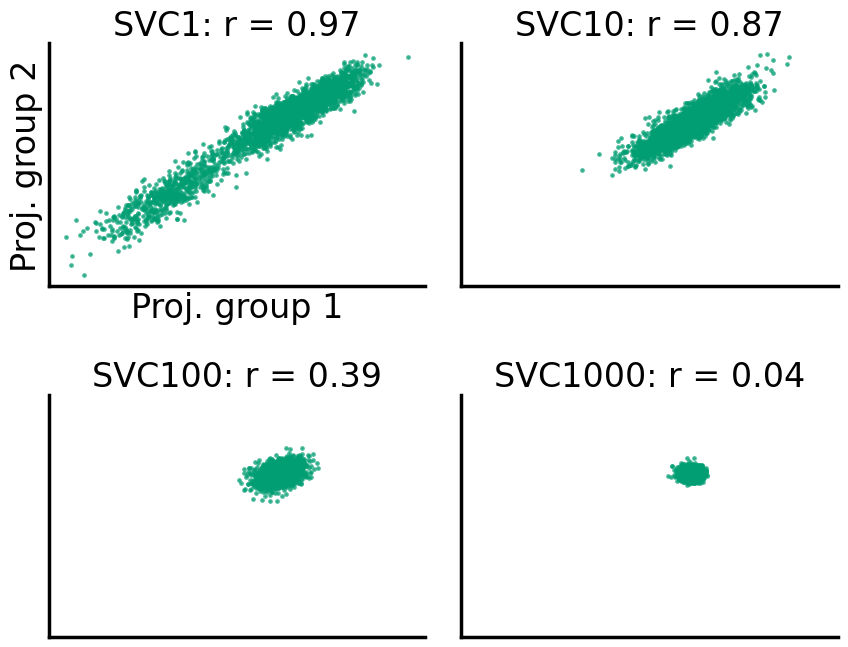

In [7]:
# Compare projections onto the same SVCs between the two neuron groups
s = 2
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9,7))
ax[0,0].scatter(SVC1[:,0], SVC2[:,0], s=s, color=GREEN, alpha=ALPHA)
ax[0,0].set_title(f"SVC1: r = {np.corrcoef(SVC1[:,0], SVC2[:,0])[0,1]:0.2f}")
ax[0,1].scatter(SVC1[:,9], SVC2[:,9], s=s, color=GREEN, alpha=ALPHA)
ax[0,1].set_title(f"SVC10: r = {np.corrcoef(SVC1[:,9], SVC2[:,9])[0,1]:0.2f}")
ax[1,0].scatter(SVC1[:,99], SVC2[:,99], s=s, color=GREEN, alpha=ALPHA)
ax[1,0].set_title(f"SVC100: r = {np.corrcoef(SVC1[:,99], SVC2[:,99])[0,1]:0.2f}")
ax[1,1].scatter(SVC1[:,990], SVC2[:,999], s=s, color=GREEN, alpha=ALPHA)
ax[1,1].set_title(f"SVC1000: r = {np.corrcoef(SVC1[:,999], SVC2[:,999])[0,1]:0.2f}")
# forget about the axes
ax[0,0].set_xlabel("Proj. group 1")
ax[0,0].set_ylabel("Proj. group 2")
sns.despine()
ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
fig.tight_layout()
plt.savefig(FIGDIR + "scatter.png", dpi=300)

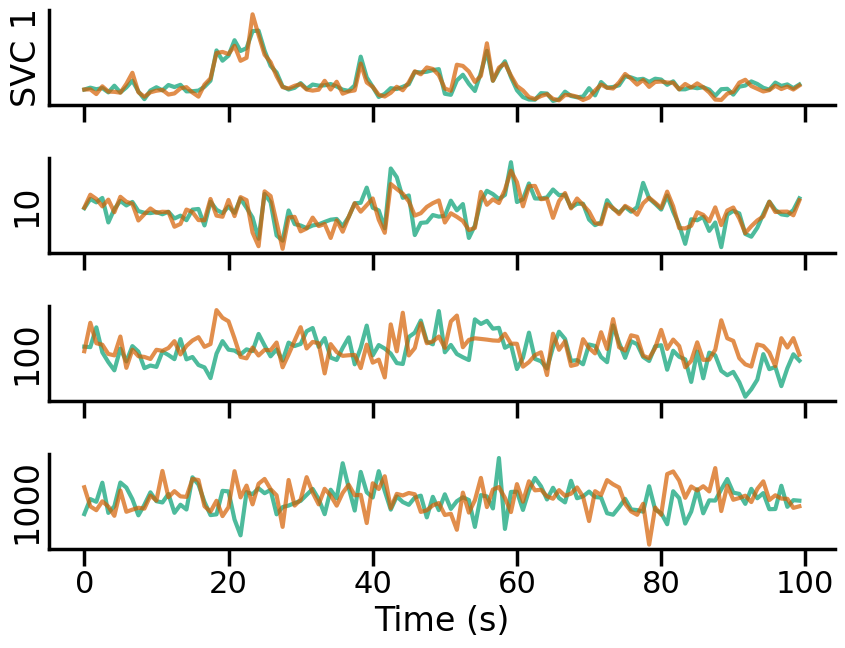

In [8]:
# Same plot but in time - first 100 bins
dimensions = [0, 9, 99, 999]
max_time = 120
fig, ax = plt.subplots(4, 1, figsize=(9,7), sharex=True)
for i, p in enumerate(dimensions):
    ax[i].plot(-SVC1[:max_time,p], color=GREEN, alpha=ALPHA)
    ax[i].plot(-SVC2[:max_time,p], color=ORANGE, alpha=ALPHA)
    if i == 0:
        ax[i].set_ylabel(f"SVC {p+1}")
    else:
        ax[i].set_ylabel(f"{p+1}")
    ax[i].set_yticks([])
    ax[i].set_xticks([])

ax[-1].set_xticks(np.arange(0, max_time+24, 24), np.arange(0, max_time, 20))
ax[-1].set_xlabel("Time (s)")
sns.despine()
fig.tight_layout()
plt.savefig(FIGDIR + "trace.png", dpi=300)